#### Importing Libraries

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import pathlib

from tensorflow import keras
from tensorflow.keras import layers

from glob import glob
from keras.models import Sequential,Model
from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

#### Data Preparation and Visualisation

In [20]:
data_dir = pathlib.Path('diabetic-retinopathy-dataset')

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2750


In [21]:
severity_labels = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

batch = 32
image_width = 256
image_height = 256

#### Resizing Data and Loading into Numpy Arrays

In [23]:
X_train = []
y_train = []

for j in severity_labels:
        folderPath = os.path.join(data_dir,j)
        for k in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,k))
            img = cv2.resize(img, (image_width,image_height))
            X_train.append(img)
            y_train.append(j)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 190/190 [00:00<00:00, 505.08it/s]


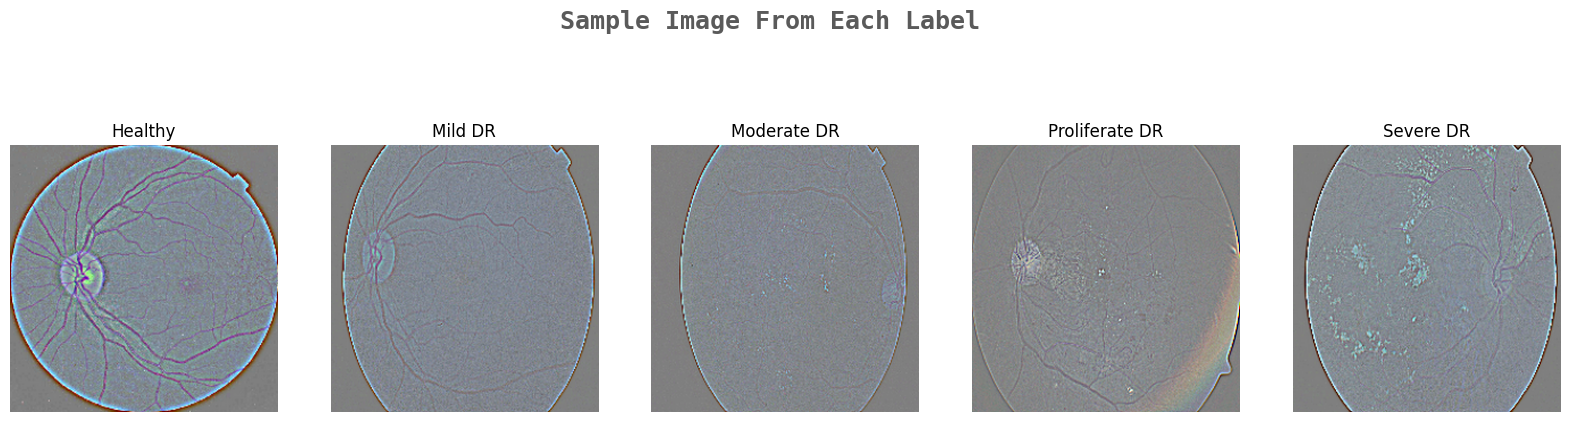

In [24]:
k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color="#313131",y=0.62,x=0.4,alpha=0.8)

for i in severity_labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

#### Shuffling Data and Splitting into Training and Testing Sets

In [25]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [26]:
X_train.shape
y_train.shape

(2750,)

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

#### Performing One Hot Encoding on labels.
One Hot Encoding converts categorical data into numeric values.

In [28]:
y_train_new = []
for i in y_train:
    y_train_new.append(severity_labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(severity_labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

#### Transfer Learning

In [29]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_height,image_width,3))

#### Modifying model output layers by adding dropout layers and kernel regularizer 'L2'

In [30]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(128,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(64,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(32,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(5,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['normalization_1[0][0]'

In [32]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

#### Writing callback functions to help with model debugging and reducing learning rate when model reach Plateau

In [34]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stop=EarlyStopping(monitor='val_loss', restore_best_weights= True, patience=5, verbose=1)

callback_options = [tensorboard,checkpoint,reduce_lr,early_stop]

In [35]:
history = model.fit(X_train,y_train,validation_split =0.1, epochs =15, verbose =1, batch_size =32,
                   callbacks = callback_options)

Epoch 1/15
70/70 [==============================] - ETA: 0s - loss: 4.0805 - accuracy: 0.5986 
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to effnet.h5
70/70 [==============================] - 1742s 24s/step - loss: 4.0805 - accuracy: 0.5986 - val_loss: 3.3134 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/15
32/70 [============>.................] - ETA: 14:35 - loss: 2.9240 - accuracy: 0.6914

In [16]:
model.save('Diabetic_Retinopathy_model.h5')

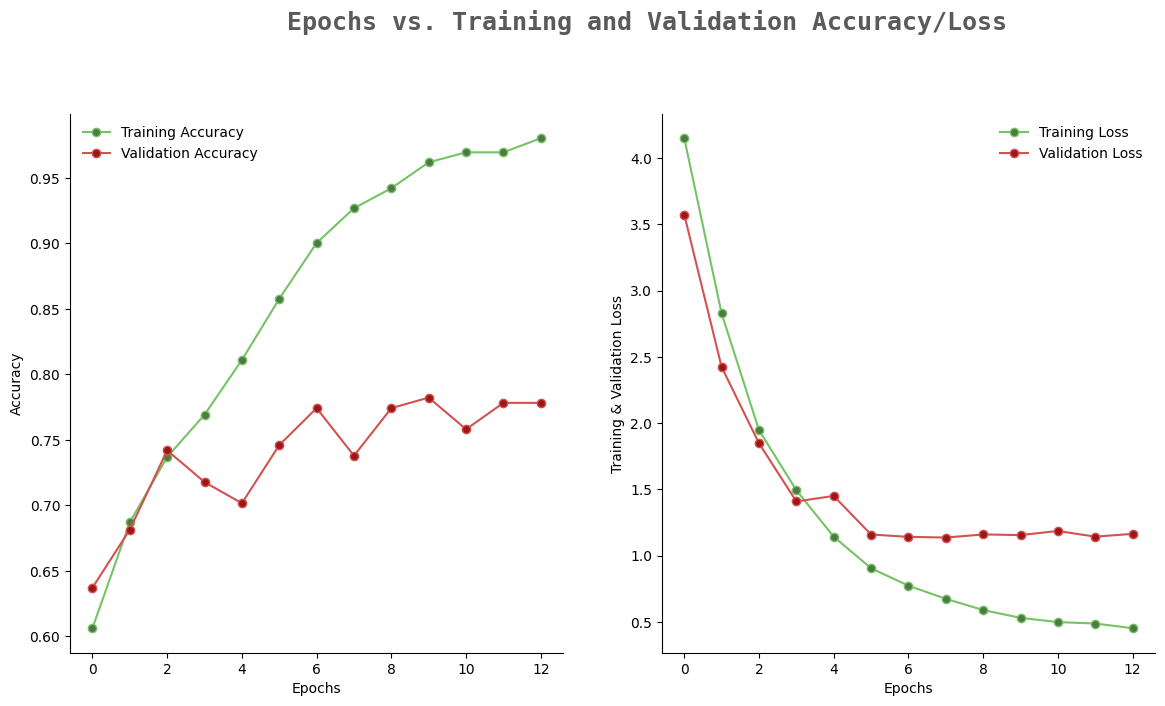

In [17]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

n_epochs = len(history.history['loss'])    
epochs = [i for i in range(n_epochs)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

#### Prediction

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

9/9 [==============================] - 27s 3s/step


In [19]:

print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        85
           1       0.60      0.72      0.65        43
           2       0.73      0.72      0.73        98
           3       0.52      0.54      0.53        28
           4       0.88      0.33      0.48        21

    accuracy                           0.75       275
   macro avg       0.73      0.66      0.67       275
weighted avg       0.76      0.75      0.74       275



In [20]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.3f}%".format(accuracy*100))

Accuracy on testing dataset: 74.909%


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# ... (rest of your code)

# Load the saved model
model = keras.models.load_model('Diabetic_Retinopathy_model.h5')

# ... (rest of your code)

# Make predictions on the test set
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
class_report = classification_report(y_test_classes, pred_classes, target_names=severity_labels)
print("Classification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, pred_classes)
print("Confusion Matrix:\n", conf_matrix)


9/9 [==============================] - 26s 3s/step
Classification Report:
                 precision    recall  f1-score   support

       Healthy       0.92      0.96      0.94        85
       Mild DR       0.60      0.72      0.65        43
   Moderate DR       0.73      0.72      0.73        98
Proliferate DR       0.52      0.54      0.53        28
     Severe DR       0.88      0.33      0.48        21

      accuracy                           0.75       275
     macro avg       0.73      0.66      0.67       275
  weighted avg       0.76      0.75      0.74       275

Confusion Matrix:
 [[82  2  1  0  0]
 [ 4 31  8  0  0]
 [ 3 16 71  8  0]
 [ 0  2 10 15  1]
 [ 0  1  7  6  7]]
